<a href="https://colab.research.google.com/github/augmentedme/sentiment-analysis/blob/master/Model_Performance_Metrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model Performance Metrics

### **Loading Libraries**

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from google.colab import drive
drive.mount("/content/drive")

In [ ]:
import re
import nltk
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
%matplotlib inline

from mlxtend.plotting import plot_confusion_matrix

from nltk.corpus import stopwords

from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score, GridSearchCV

from sklearn.metrics import classification_report,accuracy_score,precision_score,recall_score,roc_auc_score, confusion_matrix

In [ ]:
#Amazon Data
input_file = '/content/drive/My Drive/Colab Notebooks/Final Project Hi-tech Park/Sentiment Analysis/sentiment sentences/amazon_cells_labelled.txt'
amazon = pd.read_csv(input_file,delimiter='\t',header=None, names=['review', 'sentiment'])
amazon['source']='amazon'

#Yelp Data
input_file = '/content/drive/My Drive/Colab Notebooks/Final Project Hi-tech Park/Sentiment Analysis/sentiment sentences/yelp_labelled.txt'
yelp = pd.read_csv(input_file,delimiter='\t',header=None, names=['review', 'sentiment'])
yelp['source']='yelp'

#Imdb Data
input_file = '/content/drive/My Drive/Colab Notebooks/Final Project Hi-tech Park/Sentiment Analysis/sentiment sentences/imdb_labelled.txt'
imdb = pd.read_csv(input_file,delimiter='\t',header=None, names=['review', 'sentiment'])
imdb['source']='imdb'

#combine all data sets
data = pd.DataFrame()
data = pd.concat([amazon, yelp, imdb])
data['sentiment'] = data['sentiment'].astype(str)
print(data.head(5))
print(data.tail(5))

                                              review sentiment  source
0  So there is no way for me to plug it in here i...         0  amazon
1                        Good case, Excellent value.         1  amazon
2                             Great for the jawbone.         1  amazon
3  Tied to charger for conversations lasting more...         0  amazon
4                                  The mic is great.         1  amazon
                                                review sentiment source
743  I just got bored watching Jessice Lange take h...         0   imdb
744  Unfortunately, any virtue in this film's produ...         0   imdb
745                   In a word, it is embarrassing.           0   imdb
746                               Exceptionally bad!           0   imdb
747  All in all its an insult to one's intelligence...         0   imdb


### *Data Processing*

In [ ]:
# seperate required columns to clean text data

review = data.iloc[:, 0].values
senti = data.iloc[:, 1].values

In [ ]:
# Data preprocessing I

processed_reviews = []

for sentence in range(0, len(review)):
    # Remove all the special characters and punc
    processed_rev = re.sub(r'[^\w\s]', ' ', str(review[sentence]))

    # remove all single characters
    processed_rev= re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_rev)

    # Substituting multiple spaces with single space
    processed_rev = re.sub(r'\s+', ' ', processed_rev, flags=re.I)

    # Removing numbers
    processed_rev = re.sub(r'\d+', ' ', processed_rev)

    # Converting to Lowercase
    processed_rev = processed_rev.lower()
    
    processed_reviews.append(processed_rev)

In [ ]:
# creating a dataframe from clean text and sentiment score

data_clean = pd.DataFrame(processed_reviews)
data_clean.columns = ['reviews']
data_clean['senti_score'] = senti
data_clean.head()

,reviews,senti_score
0,so there is no way for me to plug it in here i...,0
1,good case excellent value,1
2,great for the jawbone,1
3,tied to charger for conversations lasting more...,0
4,the mic is great,1


In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

In [ ]:
# Data preprocessing II

#Removing stop words, stemming and Lammatization

stopword = nltk.corpus.stopwords.words('english')

def remove_stopwords(text):
    text = [word for word in text if word not in stopword]
    return text
    
data_clean = data_clean.apply(lambda x: remove_stopwords(x))

ps = nltk.PorterStemmer()

def stemming(text):
    text = [ps.stem(word) for word in text]
    return text

data_clean = data_clean.apply(lambda x: stemming(x))

wn = nltk.WordNetLemmatizer()

def lemmatizer(text):
    text = [wn.lemmatize(word) for word in text]
    return text

data_clean = data_clean.apply(lambda x: lemmatizer(x))

In [ ]:
# Splitting data into train and test datasets

X_train, X_test, y_train, y_test = train_test_split(data_clean['reviews'], data_clean['senti_score'], 
                                                    test_size=0.2, random_state=0)

### **Different Algorithm Comparison**

In [ ]:
# Building different base models with cross validation and observe their performance metrics

ABC = Pipeline([
        ("tfidf_vectorizer", TfidfVectorizer(stop_words="english")),
        ("abc", AdaBoostClassifier(random_state=0))
    ])

DTC = Pipeline([
        ("tfidf_vectorizer", TfidfVectorizer(stop_words="english")),
        ("dtc", DecisionTreeClassifier(random_state=0))
    ])

GBC = Pipeline([
        ("tfidf_vectorizer", TfidfVectorizer(stop_words="english")),
        ("dtc", GradientBoostingClassifier(random_state=0))
    ])

RFC = Pipeline([
        ("tfidf_vectorizer", TfidfVectorizer(stop_words="english")),
        ("rfc", RandomForestClassifier(random_state=0))
    ])

all_models = [
    ("ABC", ABC),
    ("DTC", DTC),
    ("GBC", GBC),
    ("RFC", RFC),
    ]
 
unsorted_scores = [(name, cross_val_score(model, X_train, y_train, cv=3, scoring='roc_auc').mean()) for name, model in all_models]
scores = pd.DataFrame(unsorted_scores, columns=['ML Model', 'roc_auc Score'])

unsorted_scores = [(name, cross_val_score(model, X_train, y_train, cv=3, scoring='recall_macro').mean()) for name, model in all_models]
scores_recall = pd.DataFrame(unsorted_scores, columns=['ML Model', 'recall Score'])
scores['Recall Score'] = scores_recall['recall Score']

unsorted_scores = [(name, cross_val_score(model, X_train, y_train, cv=3, scoring='precision_macro').mean()) for name, model in all_models]
scores_pre = pd.DataFrame(unsorted_scores, columns=['ML Model', 'Pre Score'])
scores['Precision Score'] = scores_pre['Pre Score']

unsorted_scores = [(name, cross_val_score(model, X_train, y_train, cv=3).mean()) for name, model in all_models]
scores_acc = pd.DataFrame(unsorted_scores, columns=['ML Model', 'Acc Score'])
scores['Accuracy Score'] = scores_acc['Acc Score']

scores.head()

,ML Model,roc_auc Score,Recall Score,Precision Score,Accuracy Score
0,ABC,0.756885,0.706693,0.732357,0.705647
1,DTC,0.737948,0.707366,0.712289,0.707464
2,GBC,0.806131,0.737670,0.768381,0.736581
3,RFC,0.826691,0.738058,0.743805,0.737945


In [ ]:
# Feature Extraction
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(X_train)

# Hyperparameter tunning

parameters = {
    "learning_rate": [0.05, 0.075, 0.1, 0.15, 0.2],
    "max_depth":[80,90,100],
    "max_features":["log2","sqrt"],
    "n_estimators":[200, 300, 250]
    }

grid = GridSearchCV(GradientBoostingClassifier(random_state=0), parameters, cv=3, n_jobs=-1, 
                    return_train_score=True, scoring = 'roc_auc')
grid.fit(X,y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no_c...
                 

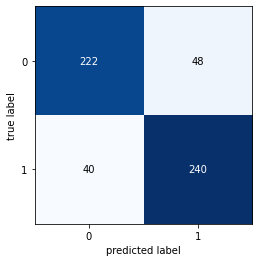

              precision    recall  f1-score   support

           0       0.85      0.82      0.83       270
           1       0.83      0.86      0.85       280

    accuracy                           0.84       550
   macro avg       0.84      0.84      0.84       550
weighted avg       0.84      0.84      0.84       550

ACC - Test:  0.84
Sensitivity - Test :  0.82
Specificity - Test :  0.86


In [ ]:
# Training classifier model with best parameters
clf = GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.05, loss='deviance', max_depth=100,
                           max_features='log2', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=300,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=0, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

clf.fit(X,y_train)

#Testing dataset
pred = clf.predict(vectorizer.transform(X_test))
cm_test = confusion_matrix(y_test,pred)
fig, ax = plot_confusion_matrix(conf_mat=cm_test)
plt.show()

print(classification_report(y_test,pred))
print('ACC - Test: ', round(accuracy_score(y_test, pred),2))

sensitivity1 = round(cm_test[0,0]/(cm_test[0,0]+cm_test[0,1]), 2)
print('Sensitivity - Test : ', sensitivity1 )

specificity1 = round(cm_test[1,1]/(cm_test[1,0]+cm_test[1,1]), 2)
print('Specificity - Test : ', specificity1)